In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def makeHito(s1,s2):
    m = len(s1)
    n = len(s2)
    #s1 on vert(rows), s2 on horizontal(cols)
    vertices = []
    count = 1
    vs = []
    es = []
    for x in range(m+1):
        for y in range(n+1):
            vs.append(count)
            count+=1
            vertices.append((x,y))
            
    g = nx.Graph()
    g.add_nodes_from(vs)
    
    draw_col = False
    draw_row = False
    edges = []
    for i in range(m):
        for j in range(n):
            row_label = s1[i]
            col_label = s2[j]
           
            if row_label == "1" and j%2 == 0:
                edges.append([(i+1,j),(i+1,j+1)])
                start = convert_index_node(i+1,j,n+1)
                end = convert_index_node(i+1,j+1,n+1)
                es.append((start,end))

            elif row_label == "0" and j%2 != 0:
                edges.append([(i+1,j),(i+1,j+1)])
                
                start = convert_index_node(i+1,j,n+1)
                end = convert_index_node(i+1,j+1,n+1)
                es.append((start,end))
                
            if col_label == "1" and i%2 == 0:
                edges.append([(i,j+1),(i+1,j+1)])
                start = convert_index_node(i,j+1,n+1)
                end = convert_index_node(i+1,j+1,n+1)
                es.append((start,end))

            elif col_label == "0" and i%2 != 0:
                edges.append([(i,j+1),(i+1,j+1)])
                start = convert_index_node(i,j+1,n+1)
                end = convert_index_node(i+1,j+1,n+1)
                es.append((start,end))

    g.add_edges_from(es)
    return g,vertices,edges

g,vs,es = makeHito("000000","000000")
nx.number_connected_components(g)






22

This aims to construct the hitomezashi graph with input strings and load it to an internal data structure that represents the hitomezashi with vertices and edges.

In [2]:
#matrix_length is the width of matrix (n)
def convert_index_node(row,col,matrix_length):
    
    return row*matrix_length + col + 1

In [3]:
def convert_node_index(node_num,matrix_length):
    row = node_num//matrix_length
    col = node_num%matrix_length -1
    if col == -1:
        #wrap around
        row -=1
        col = matrix_length - 1
    return (row,col)

In [37]:
def generate_complementary_string(s1,s2):
    
    new_s1 = ""
    for element in s1:
        if element == '1':
            new_s1+='0'
        else: new_s1+='1'
    new_s2 = ""
    for element in s2:
        if element == '1':
            new_s2+='0'
        else: new_s2+='1'
    return (new_s1,new_s2)
generate_complementary_string("001","010")

('110', '101')

Potentially we have the ability to generate complementary strings, where the original 0s become 1s and vice versa

In [12]:
import math

vrc = vcc = int(math.sqrt(len(vs)))

#create #m-1*n-1 matrix such that edges are represented as walls, and vertex of new matrix falls into the original regions
def create_regions(vertex_row_count, vertex_col_count, es):
    row_num = vertex_row_count -1
    mat_length = col_num = vertex_col_count -1
    #stores in the following format: vertex:(has_bot,has_right)
    wall_dict = {}
    regions = []
    vertex = 1
    for i in range(row_num):
        inner = []
        for j in range(col_num):
            inner.append(vertex)
            #only care about right side wall and bot side wall
            has_bot,has_right = define_walls(vertex,es,i,j,vertex_col_count)
            wall_dict[vertex] = (has_bot,has_right)
            #print(has_bot,has_right,i,j)
            vertex+=1
        regions.append(inner)
    return regions, wall_dict
    #print(wall_dict)

#returns right side wall and bot side wall's existence in form of booleans
def define_walls(vertex,es,i,j,original_length):
    top_left = i*original_length + j + 1
    top_right = top_left + 1
    bottom_right = top_right + original_length
    bottom_left = bottom_right -1
    bot_wall = (bottom_left,bottom_right)
    right_wall = (top_right,bottom_right)
    has_bot = False
    has_right = False
    if bot_wall in es:
        has_bot = True
    if right_wall in es:
        has_right = True
    return has_bot,has_right
    
    
regions,wall_dict = create_regions(vrc,vcc,g.edges())

from collections import deque
#returns number of connected regions

def count_connected_regions(regions,wall_dict):
    count = 0
    templist = []
    count = 0
    sizes = []
    for i in range(len(regions)):
        inner = []
        for j in range(len(regions[0])):
            inner.append(regions[i][j])
        templist.append(inner)
    for i in range(len(regions)):
        for j in range(len(regions[0])):
            if templist[i][j] == 0:
                continue
            sizes.append(0)
            bfs(templist,regions,i,j,wall_dict,len(regions[0]),len(regions),sizes)
            count += 1
    return count,sizes

            

def bfs(templist,regions,i,j, wall_dict,col_len,row_len,sizes):
    

   # print("bfs at region ", regions[i][j])
    if i<0 or i==row_len or j==col_len or j<0:
        return 
    tovisit = []
    tovisit.append((i,j))
    
    curr = regions[i][j]
    #every iteration: set self to 0, set neighbors to 0
    while tovisit:
        i,j = tovisit.pop(0)
        sizes[-1]+=1
        if i<0 or i==row_len or j==col_len or j<0:
            continue 
        curr = regions[i][j]
        #print(curr)
        templist[i][j] = 0
        right,left,bot,top = 0,0,0,0
        if j+1 < col_len:       
            right = templist[i][j+1]
        if i+1 < row_len:  
            bot = templist[i+1][j]
        if j-1 >= 0:  
            left = templist[i][j-1]
        if i-1 >= 0:  
            top = templist[i-1][j]    
        # check if neighbors are actually connected
        left_is_neighbor = is_neighbor(curr,left,wall_dict,col_len)
        right_is_neighbor = is_neighbor(curr,right,wall_dict,col_len)
        top_is_neighbor = is_neighbor(curr,top,wall_dict,col_len)
        bot_is_neighbor = is_neighbor(curr,bot,wall_dict,col_len)
        if left_is_neighbor:
            tovisit.append((i,j-1))
            templist[i][j-1] = 0
        if right_is_neighbor:
            tovisit.append((i,j+1))
            templist[i][j+1] = 0
        if top_is_neighbor:
            tovisit.append((i-1,j))
            templist[i-1][j] = 0
        if bot_is_neighbor:
            tovisit.append((i+1,j))
            templist[i+1][j] = 0
   
        
    

                   
                
    
def is_neighbor(region1, region2, wall_dict,mat_length):
    #signals the beginning of bfs
    if region1 == -1 or region2 == -1:
        return True
    #signals visited cells
    if region1 == 0 or region2 == 0:
        return False
    has_bot1,has_right1 = wall_dict[region1]
    has_bot2,has_right2 = wall_dict[region2]
    if region2 == region1+1:
        if has_right1:
            return False
        else:
            if region2%mat_length == 1 and region1%mat_length == 0:
                return False
            else:
                return True
            
    elif region2 ==region1-1:
        if has_right2:
            return False
        else:
            #prevent side to side wraps
            #can delete this line to encourage side wraps -> Torus
            if region1%mat_length == 1 and region2%mat_length == 0:
                return False
            else:
                return True
    elif region2 == region1-mat_length:
        if has_bot2:
            return False
        else:
            return True
    elif region2==region1+mat_length:
        if has_bot1:
            return False
        else:
            return True
    else:
        return False
count_connected_regions(regions,wall_dict)
# print(es)
# print(g.edges())
# print(count)

(10, [27, 1, 1, 1, 1, 1, 1, 1, 1, 1])

This is where the main calculations happen. The essential algorithm here is converting the original graph into a new "cell graph" such that each cell has 4 walls defined. The cells are defined to be neighbors if they don't share a wall in between them, and they are immediate neighbors to each other. In this way, we are able to calculate the total numbers of connected regions, as well as the number of cells in each connected region, and find the correlation between that and the string length.

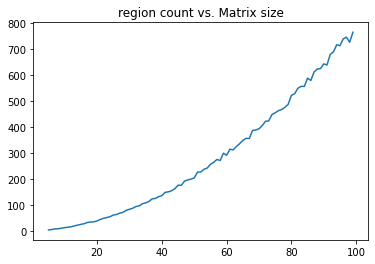

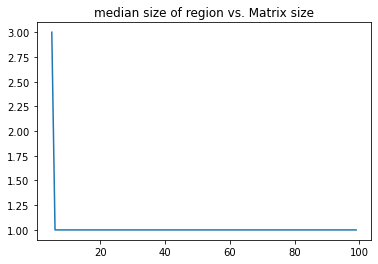

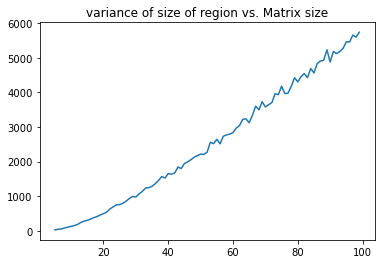

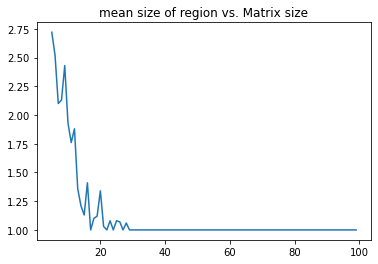

In [85]:
import random


# Function to create the
# random binary string
#generate markove chain (propability of distribution dependent on previous)
#markov random
def rand_binary_string(p):
   
    # Variable to store the
    # string
    key1 = ""
    # Loop to find the string
    # of desired length
    for i in range(p):   
        # randint function to generate
        # 0, 1 randomly and converting
        # the result into str
        temp = str(random.randint(0, 1))
        # Concatenation the random 0, 1
        # to the final result
        key1 += temp  
        
    return(key1)

#generation 2 random strings of max length 20
def simulation(strlen):
    strlen1 = strlen2 = strlen
    
    str1 = rand_binary_string(strlen1)
    str2 = rand_binary_string(strlen2)
    #print(str1,str2)
    g,vs,es = makeHito(str1,str2)
    #print(g.edges())
    regions,wall_dict = create_regions(strlen1+1, strlen2+1, g.edges())
    
    #print(regions)
    count,sizes = count_connected_regions(regions,wall_dict)
    return count,sizes

import statistics as st
def run_simulation(loopNum):
    #dict store: strlen: average region count
    dict = {}
    median_sizes = {}
    var_sizes = {}
    mean_sizes= {}
    for strlen in range(5,100):
        count = 0
        med = []
        var = []
        mean = []
        for i in range(loopNum):
            regionNum, sizes = simulation(strlen)
            #print(sizes)
            med.append(st.median(sizes))
            var.append(st.variance(sizes))
            mean.append(st.mean(sizes))
            count += regionNum
        dict[strlen] = count/loopNum
        #print(med)
        median_sizes[strlen] = st.median(med)
        mean_sizes[strlen] = st.mean(med)
        var_sizes[strlen] = st.median(var)
    
    return dict,median_sizes,var_sizes,mean_sizes

dict,median_sizes,var_sizes,mean_sizes = run_simulation(50)
lists1 = sorted(dict.items()) # sorted by key, return a list of tuples
x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
plt.plot(x1, y1)
plt.title("region count vs. Matrix size")
plt.show()

lists2 = sorted(median_sizes.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.title("median size of region vs. Matrix size")
plt.show()

lists3 = sorted(var_sizes.items()) # sorted by key, return a list of tuples
x3, y3 = zip(*lists3) # unpack a list of pairs into two tuples
plt.plot(x3, y3)
plt.title("variance of size of region vs. Matrix size")
plt.show()

lists4 = sorted(mean_sizes.items()) # sorted by key, return a list of tuples
x4, y4 = zip(*lists4) # unpack a list of pairs into two tuples
plt.plot(x4, y4)
plt.title("mean size of region vs. Matrix size")
plt.show()

#plt.legend()
#plot size of matrix over number of regions (number of squares per region)
#variance of size of regions

By running simulations on the data, we currently estimate the correlation between length of bit strings and number of connected regions is parabolic by nature. The next step of the way is to calculate the variance of size of regions. In addition, we can change our definition of a "neighbor" to manipulate the intrinsic topology of the graph. For instance, we can allow for the left-right wrap around and a top-bottom wrap around to allow for the pattern to become a torus. Then, we can connect the top right to the bottom left, top left to bottom right, and make the top and bottom a collective boundary so that we would have a mobius strip. To take this even further, we can try to calculate the Euler number of the connected regions, as most of them are either toruses or toruses with holes in it, and analyze that data.

Now we modify our previous simulations to see the results we get when we change the probabilities

In [77]:
#l is the length of the string, same is the probability of next string being the same as previous, and diff is the opposite
def markov_binary_string(l,same,diff,first):
   
    # Variable to store the
    # string
    key1 = ""
    key1+=first
    # Loop to find the string
    # of desired length
    temp = first
    candidates = [0,1]
    for i in range(l-1):   
        if temp == "1":
            temp = str(random.choices(candidates,weights=(diff,same),k=1)[0])
        if temp == "0":
            temp = str(random.choices(candidates,weights=(same,diff),k=1)[0])   
       
        #print(temp)
        key1 += temp
        
    return(key1)
#markov_binary_string(5,60,40,"0")

def fixed_probability_string(l,p0,p1):
    key1 = ""
   
    candidates = [0,1]
    for i in range(l):   
      
        temp = str(random.choices(candidates,weights=(p0,p1),k=1)[0])   
       
        #print(temp)
        key1 += temp
        
    return(key1)
#fixed_probability_string(5,60,40)




Below is a simulation with a markov probability string where 0 is fed as initial character, and matrix size is fixed at 30

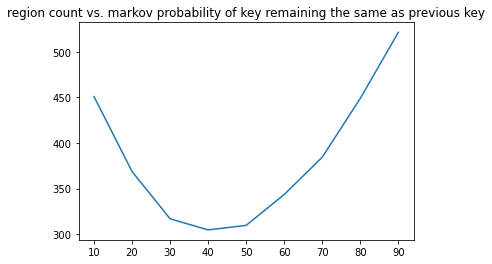

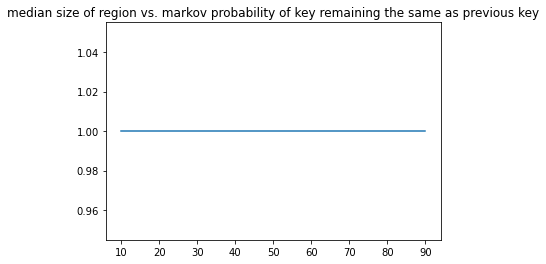

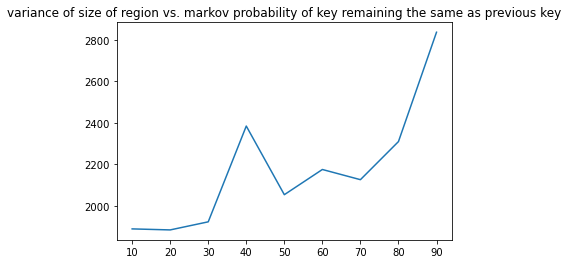

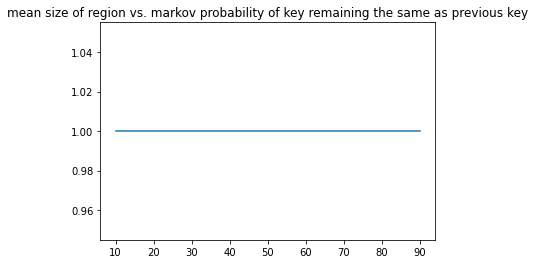

In [79]:
def simulation(strlen,same,diff,first):
    strlen1 = strlen2 = strlen
    
    str1 = markov_binary_string(strlen1,same,diff,first)
    str2 = markov_binary_string(strlen2,same,diff,first)
    #print(str1,str2)
    g,vs,es = makeHito(str1,str2)
    #print(g.edges())
    regions,wall_dict = create_regions(strlen1+1, strlen2+1, g.edges())
    
    #print(regions)
    count,sizes = count_connected_regions(regions,wall_dict)
    return count,sizes

import statistics as st
def run_simulation(loopNum):
    #dict store: strlen: average region count
    dict = {}
    median_sizes = {}
    var_sizes = {}
    mean_sizes= {}
    same = 10
    diff = 100-same
    strlen = 50
    while same < 100:
        count = 0
        med = []
        var = []
        mean = []
        for i in range(loopNum):
            regionNum, sizes = simulation(strlen,same,diff,"0")
            #print(sizes)
            med.append(st.median(sizes))
            var.append(st.variance(sizes))
            mean.append(st.mean(sizes))
            count += regionNum
        dict[same] = count/loopNum
        #print(med)
        median_sizes[same] = st.median(med)
        mean_sizes[same] = st.mean(med)
        var_sizes[same] = st.median(var)
        same+=10
        diff-=10
    return dict,median_sizes,var_sizes,mean_sizes
dict,median_sizes,var_sizes,mean_sizes = run_simulation(50)
lists1 = sorted(dict.items()) # sorted by key, return a list of tuples
x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
plt.plot(x1, y1)
plt.title("region count vs. markov probability of key remaining the same as previous key")
plt.show()

lists2 = sorted(median_sizes.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.title("median size of region vs. markov probability of key remaining the same as previous key")
plt.show()

lists3 = sorted(var_sizes.items()) # sorted by key, return a list of tuples
x3, y3 = zip(*lists3) # unpack a list of pairs into two tuples
plt.plot(x3, y3)
plt.title("variance of size of region vs. markov probability of key remaining the same as previous key")
plt.show()

lists4 = sorted(mean_sizes.items()) # sorted by key, return a list of tuples
x4, y4 = zip(*lists4) # unpack a list of pairs into two tuples
plt.plot(x4, y4)
plt.title("mean size of region vs. markov probability of key remaining the same as previous key")
plt.show()

Below is a simulation with a changing fixed probability, and matrix size is fixed at 30

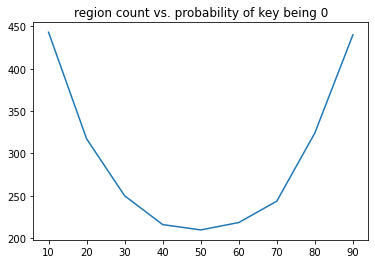

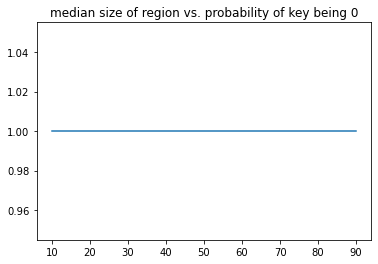

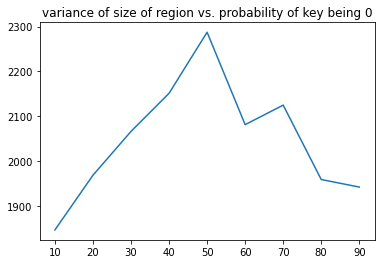

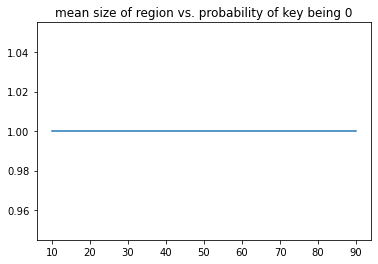

In [83]:
def simulation(strlen,p0,p1):
    strlen1 = strlen2 = strlen
    
    str1 = fixed_probability_string(strlen1,p0,p1)
    str2 = fixed_probability_string(strlen2,p0,p1)
    #print(str1,str2)
    g,vs,es = makeHito(str1,str2)
    #print(g.edges())
    regions,wall_dict = create_regions(strlen1+1, strlen2+1, g.edges())
    
    #print(regions)
    count,sizes = count_connected_regions(regions,wall_dict)
    return count,sizes

import statistics as st
def run_simulation(loopNum):
    #dict store: strlen: average region count
    dict = {}
    median_sizes = {}
    var_sizes = {}
    mean_sizes= {}
    p0 = 10
    p1 = 100-p0
    strlen = 50
    while p0 < 100:
        count = 0
        med = []
        var = []
        mean = []
        for i in range(loopNum):
            regionNum, sizes = simulation(strlen,p0,p1)
            #print(sizes)
            med.append(st.median(sizes))
            var.append(st.variance(sizes))
            mean.append(st.mean(sizes))
            count += regionNum
        dict[p0] = count/loopNum
        #print(med)
        median_sizes[p0] = st.median(med)
        mean_sizes[p0] = st.mean(med)
        var_sizes[p0] = st.median(var)
        p0+=10
        p1-=10
    return dict,median_sizes,var_sizes,mean_sizes
dict,median_sizes,var_sizes,mean_sizes = run_simulation(50)
lists1 = sorted(dict.items()) # sorted by key, return a list of tuples
x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
plt.plot(x1, y1)
plt.title("region count vs. probability of key being 0")
plt.show()

lists2 = sorted(median_sizes.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.title("median size of region vs. probability of key being 0")
plt.show()

lists3 = sorted(var_sizes.items()) # sorted by key, return a list of tuples
x3, y3 = zip(*lists3) # unpack a list of pairs into two tuples
plt.plot(x3, y3)
plt.title("variance of size of region vs. probability of key being 0")
plt.show()

lists4 = sorted(mean_sizes.items()) # sorted by key, return a list of tuples
x4, y4 = zip(*lists4) # unpack a list of pairs into two tuples
plt.plot(x4, y4)
plt.title("mean size of region vs. probability of key being 0")
plt.show()

Below is the analysis of region counts/medians/means of a topological torus

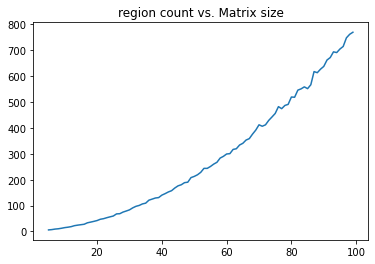

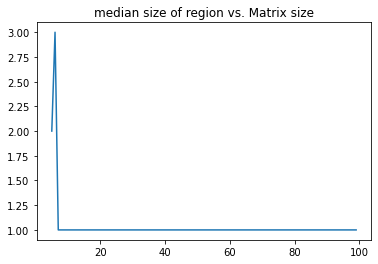

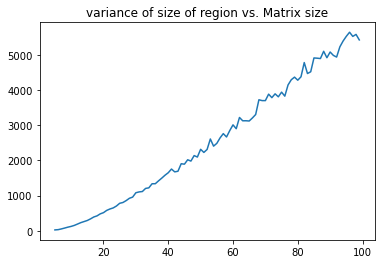

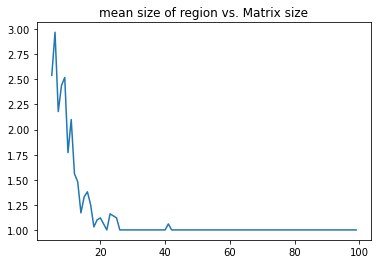

In [84]:
def count_connected_regions(regions,wall_dict):
    count = 0
    templist = []
    count = 0
    sizes = []
    for i in range(len(regions)):
        inner = []
        for j in range(len(regions[0])):
            inner.append(regions[i][j])
        templist.append(inner)
    for i in range(len(regions)):
        for j in range(len(regions[0])):
            if templist[i][j] == 0:
                continue
            sizes.append(0)
            bfs(templist,regions,i,j,wall_dict,len(regions[0]),len(regions),sizes)
            count += 1
    return count,sizes

            

def bfs(templist,regions,i,j, wall_dict,col_len,row_len,sizes):
    

   # print("bfs at region ", regions[i][j])
    if i<0 or i==row_len or j==col_len or j<0:
        return 
    tovisit = []
    tovisit.append((i,j))
    
    curr = regions[i][j]
    #every iteration: set self to 0, set neighbors to 0
    while tovisit:
        i,j = tovisit.pop(0)
        sizes[-1]+=1
        if i<0 or i==row_len or j==col_len or j<0:
            continue 
        curr = regions[i][j]
        #print(curr)
        templist[i][j] = 0
        right,left,bot,top = 0,0,0,0
        if j+1 < col_len:       
            right = templist[i][j+1]
        if i+1 < row_len:  
            bot = templist[i+1][j]
        if j-1 >= 0:  
            left = templist[i][j-1]
        if i-1 >= 0:  
            top = templist[i-1][j]    
        # check if neighbors are actually connected
        left_is_neighbor = is_neighbor(curr,left,wall_dict,col_len)
        right_is_neighbor = is_neighbor(curr,right,wall_dict,col_len)
        top_is_neighbor = is_neighbor(curr,top,wall_dict,col_len)
        bot_is_neighbor = is_neighbor(curr,bot,wall_dict,col_len)
        if left_is_neighbor:
            tovisit.append((i,j-1))
            templist[i][j-1] = 0
        if right_is_neighbor:
            tovisit.append((i,j+1))
            templist[i][j+1] = 0
        if top_is_neighbor:
            tovisit.append((i-1,j))
            templist[i-1][j] = 0
        if bot_is_neighbor:
            tovisit.append((i+1,j))
            templist[i+1][j] = 0
   
        
    

                   
                
    
def is_neighbor(region1, region2, wall_dict,mat_length):
    #signals the beginning of bfs
    if region1 == -1 or region2 == -1:
        return True
    #signals visited cells
    if region1 == 0 or region2 == 0:
        return False
    has_bot1,has_right1 = wall_dict[region1]
    has_bot2,has_right2 = wall_dict[region2]
    if region2 == region1+1:
        if has_right1:
            return False
        else:
            
            return True
            
    elif region2 ==region1-1:
        if has_right2:
            return False
        else:
            
            return True
    elif region2 == region1-mat_length:
        if has_bot2:
            return False
        else:
            return True
    elif region2==region1+mat_length:
        if has_bot1:
            return False
        else:
            return True
    else:
        return False
    
def rand_binary_string(p):
   
    # Variable to store the
    # string
    key1 = ""
    # Loop to find the string
    # of desired length
    for i in range(p):   
        # randint function to generate
        # 0, 1 randomly and converting
        # the result into str
        temp = str(random.randint(0, 1))
        # Concatenation the random 0, 1
        # to the final result
        key1 += temp  
        
    return(key1)

#generation 2 random strings of max length 20
def simulation(strlen):
    strlen1 = strlen2 = strlen
    
    str1 = rand_binary_string(strlen1)
    str2 = rand_binary_string(strlen2)
    #print(str1,str2)
    g,vs,es = makeHito(str1,str2)
    #print(g.edges())
    regions,wall_dict = create_regions(strlen1+1, strlen2+1, g.edges())
    
    #print(regions)
    count,sizes = count_connected_regions(regions,wall_dict)
    return count,sizes

import statistics as st
def run_simulation(loopNum):
    #dict store: strlen: average region count
    dict = {}
    median_sizes = {}
    var_sizes = {}
    mean_sizes= {}
    for strlen in range(5,100):
        count = 0
        med = []
        var = []
        mean = []
        for i in range(loopNum):
            regionNum, sizes = simulation(strlen)
            #print(sizes)
            med.append(st.median(sizes))
            var.append(st.variance(sizes))
            mean.append(st.mean(sizes))
            count += regionNum
        dict[strlen] = count/loopNum
        #print(med)
        median_sizes[strlen] = st.median(med)
        mean_sizes[strlen] = st.mean(med)
        var_sizes[strlen] = st.median(var)
    
    return dict,median_sizes,var_sizes,mean_sizes

dict,median_sizes,var_sizes,mean_sizes = run_simulation(50)
lists1 = sorted(dict.items()) # sorted by key, return a list of tuples
x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
plt.plot(x1, y1)
plt.title("region count vs. Matrix size")
plt.show()

lists2 = sorted(median_sizes.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
plt.plot(x2, y2)
plt.title("median size of region vs. Matrix size")
plt.show()

lists3 = sorted(var_sizes.items()) # sorted by key, return a list of tuples
x3, y3 = zip(*lists3) # unpack a list of pairs into two tuples
plt.plot(x3, y3)
plt.title("variance of size of region vs. Matrix size")
plt.show()

lists4 = sorted(mean_sizes.items()) # sorted by key, return a list of tuples
x4, y4 = zip(*lists4) # unpack a list of pairs into two tuples
plt.plot(x4, y4)
plt.title("mean size of region vs. Matrix size")
plt.show()

